In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for visualizations
sns.set_theme(style='darkgrid')
sns.set_palette('husl')

# Read the cleaned data
f1_data = pd.read_csv('../data/f1_data_cleaned.csv')
weather_data = pd.read_csv('../data/global_weather_2010_2023.csv')

## 1. Weather Impact Analysis

First, let's examine how global weather anomalies correlate with race outcomes.

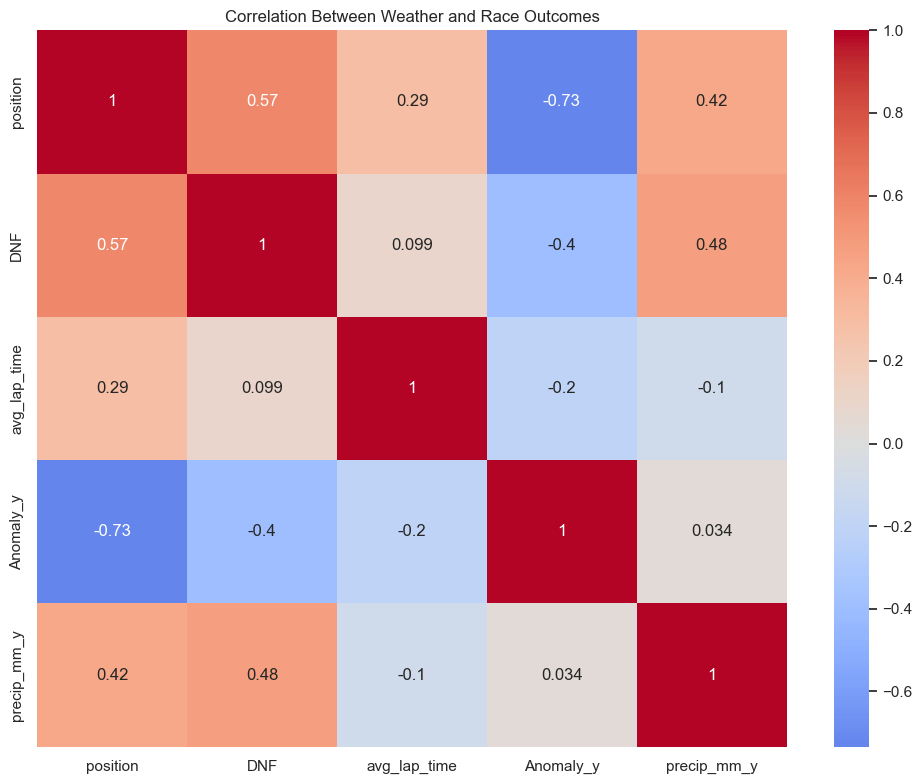

In [2]:
# Consider 'Finished' and '+X Lap(s)' as not DNF, everything else as DNF
f1_data['DNF'] = ~f1_data['status'].str.contains('Finished|\\+\\d+ Lap', case=False, na=False)
f1_data['DNF'] = f1_data['DNF'].astype(int)
#  Merge weather data with F1 data
merged_data = pd.merge(
    f1_data, weather_data,
    left_on='season',
    right_on='Year',
    how='left'
)

# Calculate yearly aggregates
yearly_stats = merged_data.groupby('season').agg({
    'position': 'mean',
    'DNF': 'sum',
    'avg_lap_time': 'mean',
    'Anomaly_y': 'first',      # Use 'Anomaly' instead of 'temp_anomaly_C'
    'precip_mm_y': 'first'
}).reset_index()

# Create correlation matrix
correlation_matrix = yearly_stats[['position', 'DNF', 'avg_lap_time', 'Anomaly_y', 'precip_mm_y']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Weather and Race Outcomes')
plt.tight_layout()
plt.savefig('../results/weather_vs_outcome.png')  
plt.show()

## 2. Driver and Constructor Performance Analysis

Driver and constructor performance over time.

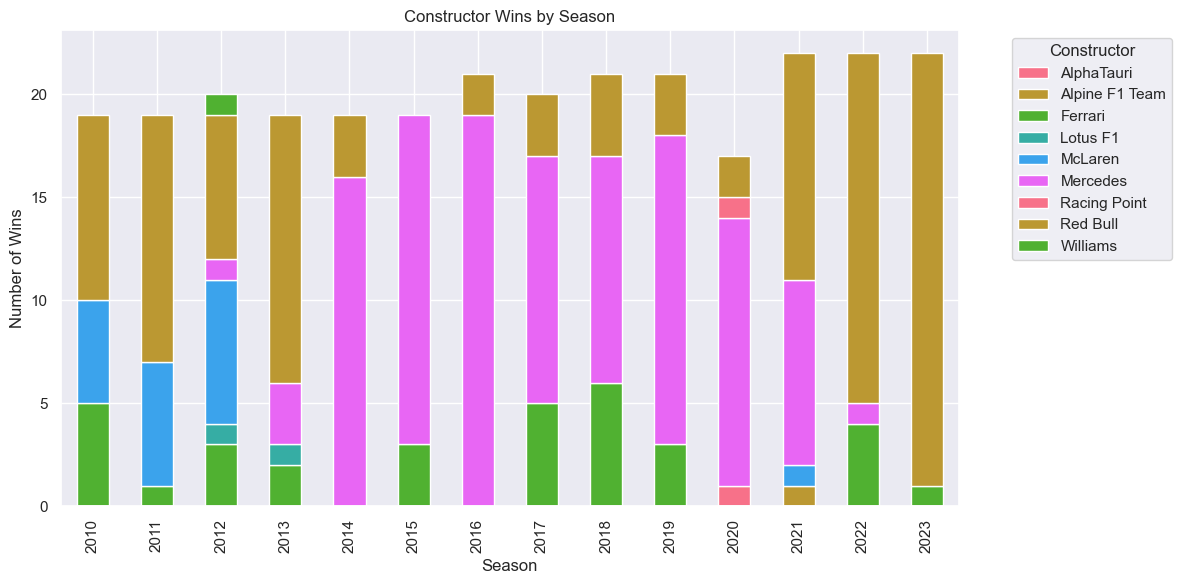

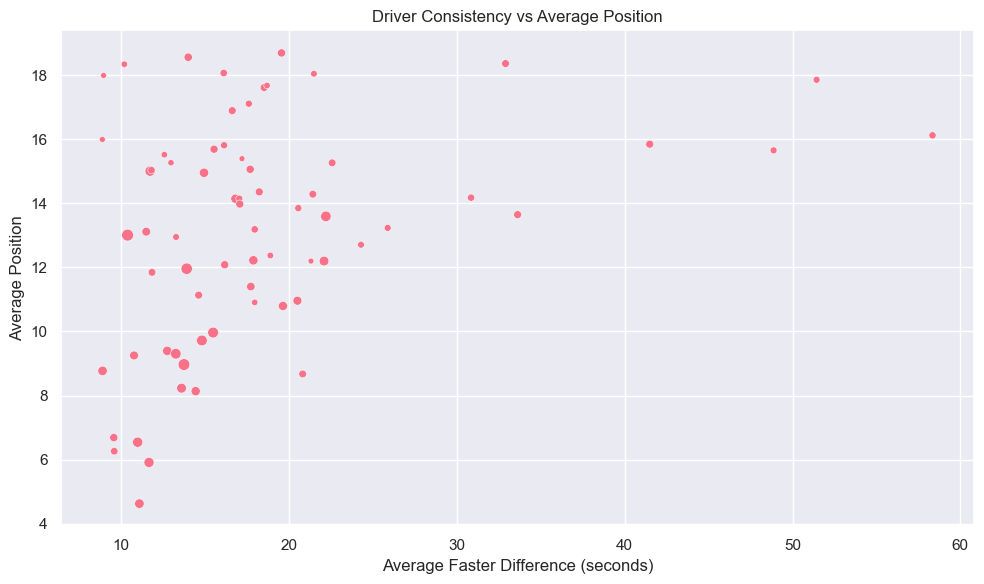

In [3]:
# Calculate constructor dominance
constructor_wins = f1_data[f1_data['position'] == 1].groupby(['season', 'constructor']).size().unstack()

# Plot constructor wins over time
constructor_wins.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Constructor Wins by Season')
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.legend(title='Constructor', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('../results/constructor_win_byseason.png')  
plt.show()

# Calculate driver consistency
driver_consistency = f1_data.groupby('driver_id').agg({
    'faster_difference': 'mean',
    'position': 'mean',
    'DNF': 'sum'
}).sort_values('faster_difference')

# Plot driver consistency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=driver_consistency,
    x='faster_difference',
    y='position',
    size='DNF',
    legend=False
)
plt.title('Driver Consistency vs Average Position')
plt.xlabel('Average Faster Difference (seconds)')
plt.ylabel('Average Position')
plt.tight_layout()
plt.savefig('../results/consistency_vs_averagePlacing.png')  
plt.show()

## 3. Track-Specific Analysis

Which drivers perform best at specific circuits?

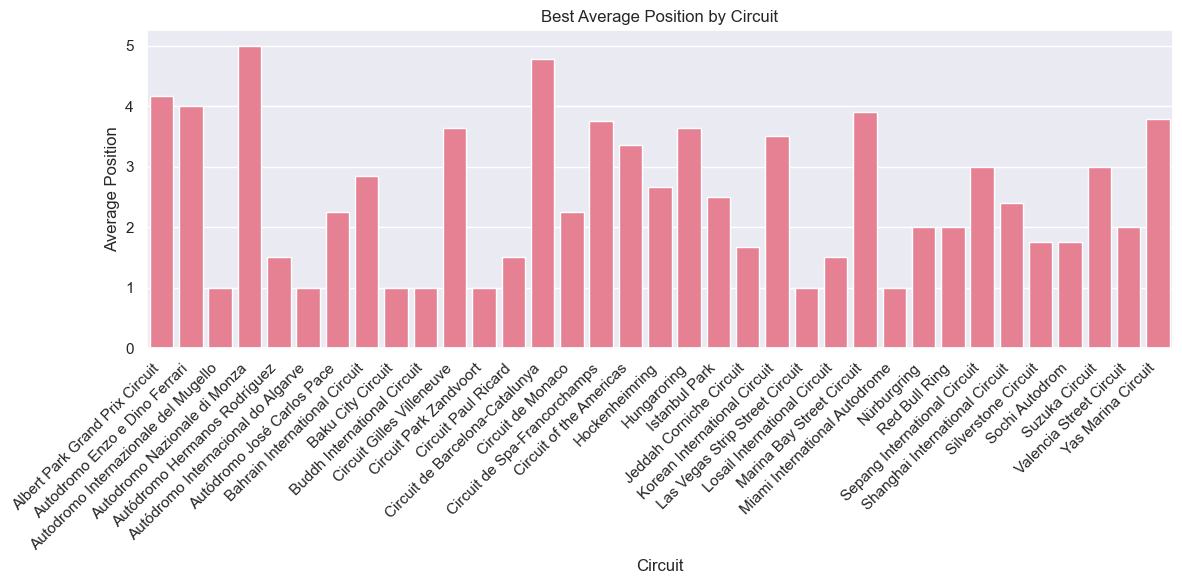

In [4]:
# Calculate track-specific performance
track_performance = f1_data.groupby(['circuit', 'driver_id']).agg({
    'position': 'mean',
    'avg_lap_time': 'mean',
    'faster_difference': 'mean'
}).reset_index()

# Find best driver per track
best_drivers = track_performance.loc[track_performance.groupby('circuit')['position'].idxmin()]

# Plot track dominance
plt.figure(figsize=(12, 6))
sns.barplot(data=best_drivers, x='circuit', y='position')
plt.title('Best Average Position by Circuit')
plt.xlabel('Circuit')
plt.ylabel('Average Position')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../results/best_avg_position_by_circuit.png')  
plt.show()

## 4. Time Series Analysis

Performance metric change over time

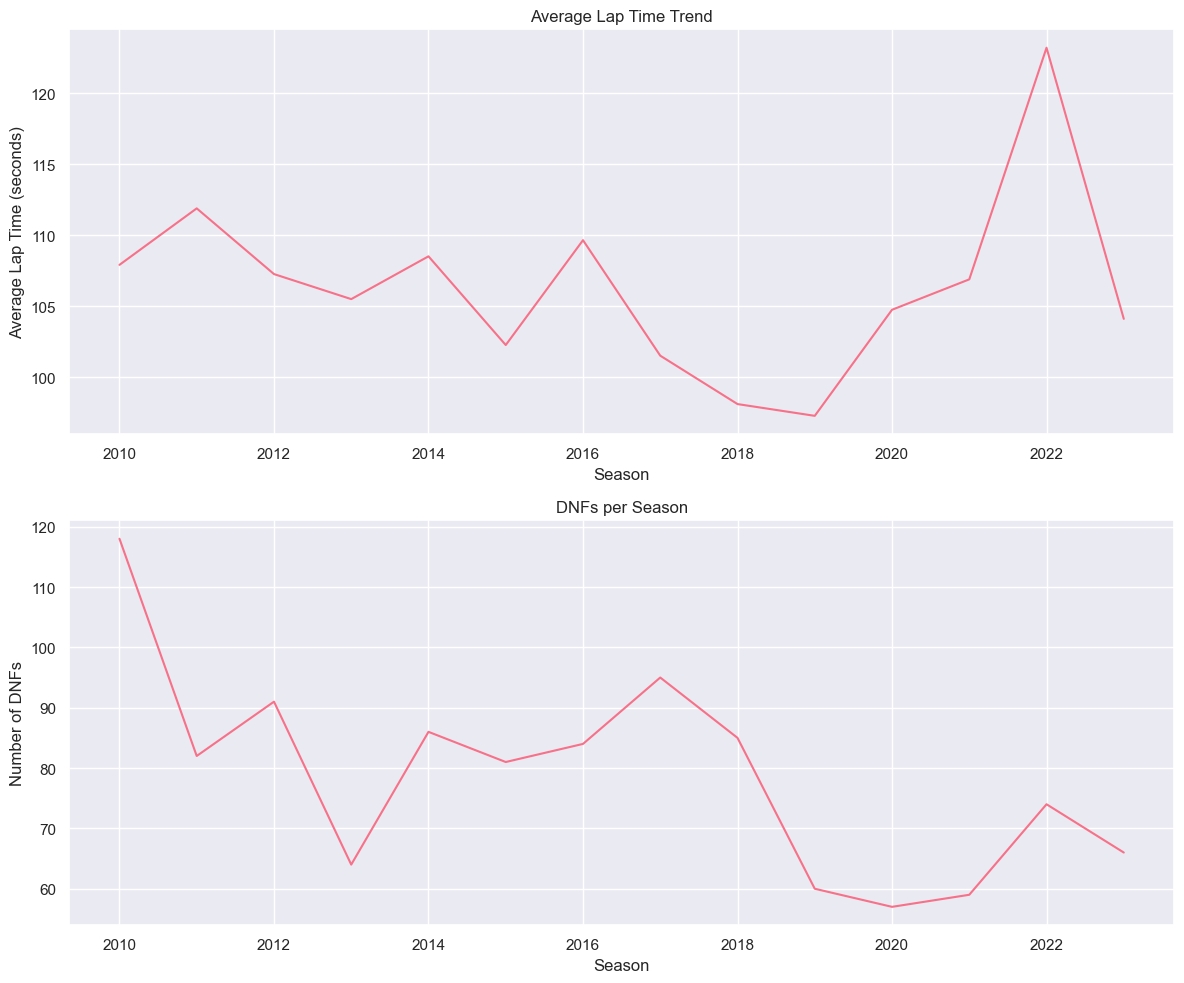

In [5]:
# Calculate yearly performance trends
yearly_trends = f1_data.groupby('season').agg({
    'avg_lap_time': 'mean',
    'faster_difference': 'mean',
    'DNF': 'sum'
}).reset_index()

# Plot performance trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Average lap time trend
sns.lineplot(data=yearly_trends, x='season', y='avg_lap_time', ax=ax1)
ax1.set_title('Average Lap Time Trend')
ax1.set_xlabel('Season')
ax1.set_ylabel('Average Lap Time (seconds)')

# DNF trend
sns.lineplot(data=yearly_trends, x='season', y='DNF', ax=ax2)
ax2.set_title('DNFs per Season')
ax2.set_xlabel('Season')
ax2.set_ylabel('Number of DNFs')

plt.tight_layout()
plt.savefig('../results/time_series_Trend.png')  
plt.show()